# Introduction

This project was conducted by Pierre Bourdon & Eike Wefelnberg. After briefly analysing the daily returns on the S&P500 with respect to stylized facts of asset returns, we built an artificial recurrent neural network (RNN) using the Long Short-Term Memory (LSTM) architecture. The intention was to employ daily time-series data on the LSTM model in order to predict the level of the S&P500. Finally, we compared the predictive power of the LSTM model with the performance of a more commonly employed feedforward Deep Neural Network (DNN).

Disclaimer: This project is for practice and educational purposes only and does not intend to give any recommendations on trading strategies or forecasts. 

# Importing & Preparing Data

The data was downloaded from the Center for Research in Security Prices (CRSP) (http://crsp.org/). It includes daily return and level data of the S&P500 from 01.01.1963 - 31.12.2019.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving sp.csv to sp.csv


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import io
df = pd.read_csv(io.BytesIO(uploaded['sp.csv'])) 
df = df.sort_values(by = 'DATE')
df.head()

,DATE,sprtrn,spindx
0,19630102,-0.006498,62.69
1,19630103,0.016430,63.72
2,19630104,0.006434,64.13
3,19630107,-0.000156,64.12
4,19630108,0.009669,64.74


# Exploratory Analysis on Stylized Facts of Asset Returns

Let's calculate log returns as they are assumed to better fit the normality assumption.

In [0]:
#Calculate log returns
df['lnret'] = np.log(1+df['sprtrn'])

Let's check the normality assumption by conducting a Jarque-Bera Test. We will test the null hypothesis that daily returns are normally distributed. 

In [0]:
stats.jarque_bera(df['lnret'])

(435247.0031345941, 0.0)

With a p-value of close to 0 and a test statistic of 435,247, we can clearly reject the null hypothesis.
This suggests that daily log returns are not normally distributed. 

Let's figure out where the abnormality comes from.

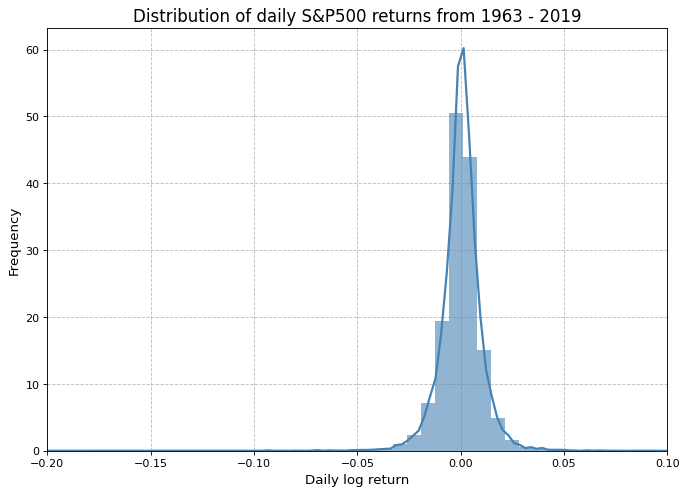

In [0]:
%matplotlib inline
fig = plt.figure(figsize=(10,7), dpi= 80)
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(df['lnret'], label='daily log returns', color = 'steelblue', **kwargs)
plt.xlim(-0.2,0.1)
plt.title('Distribution of daily S&P500 returns from 1963 - 2019', fontsize = 15)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.xlabel('Daily log return', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.show()

In [0]:
stats.kurtosis(df['lnret'])

26.906224601408255

[Scipy.stats.kurtosis](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html) calculates Fisher's definition of kurtosis by default. Thus, 3 (the kurtosis of a normal distribution) is subtracted from the result and the 26.90 is considered excess kurtosis. Consequently, we can observe that the distribution is leptokurtic, i.e. has fat tails, and the probability for the occurence of extreme outliers is larger than in a normal distribution.

In [0]:
stats.skew(df['lnret'])

-1.0119023518563397

As expected, we get a negtative skewness coefficient depicting that the daily log returns are negatively skewed. 

The leptokurtic negatively skewed distribution of returns is actually in line with the so called **stylized facts of asset returns** (Cont 2001).

## Volatiltiy Clustering

A lot of empirical evidence has been provided on **volatility clustering**. This means that large variations in prices (e.g. in times of macroeconomic uncertainties) are likely followed by repeated heavy price variations. Let's visualise the squared log returns and see whether we can find evidence for this phenomenon for the S&P500. 

In [0]:
#Calculate squared log returns
df['sqlnret'] = df['lnret']**2

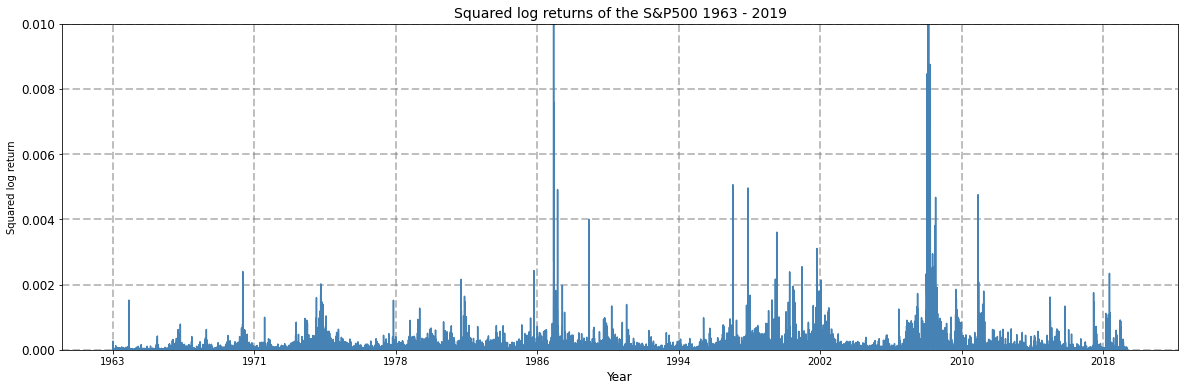

In [0]:
%matplotlib inline
df['YEAR'] = df['DATE'].astype(str)
df['YEAR']= df['YEAR'].str.slice(0, 4, 1)
df = df.set_index('YEAR')
fig = df.sqlnret.plot(figsize = (20,6), color = 'steelblue')
plt.yticks(fontsize = 12)
plt.ylim(0,0.01)
plt.ylabel('Squared log return', fontsize = 10)
plt.xticks(fontsize = 10)
plt.xlabel ('Year', fontsize = 12)
plt.title('Squared log returns of the S&P500 1963 - 2019', fontsize = 14)
df = df.reset_index()
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--', linewidth=2)
plt.show()

We can clearly see volatility clustering in times of financial and macroeconomic uncertainties (global financial crisis, dot-com bubble, etc.). Therefore, we can conclude that the log returns are not independent and identically distributed. This is a major assumption for the random walk model, which is why our findings support the hypothesis that S&P500’s log returns do not follow a random walk.

## Autocorrelations of returns

This idea can further be analysed when looking at the autocorrelation of squared log returns. The autocorrelation depicts how strongly a signal correlates with a delayed (or lagged) copy of itself. 

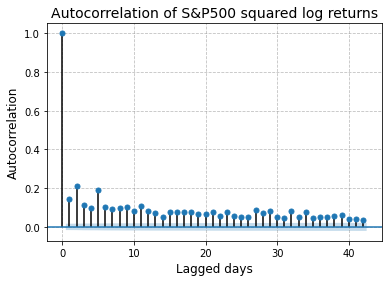

In [0]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['sqlnret'])
plt.title('Autocorrelation of S&P500 squared log returns', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Lagged days', fontsize = 12)
plt.xticks(fontsize = 10)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')

As we can see **squared log returns** display a moderate autocorrelation with their lagged copy. This further strengthens the thesis, that volatility clustering exists. 

Let's plot the autocorrelation of the level of the S&P500.

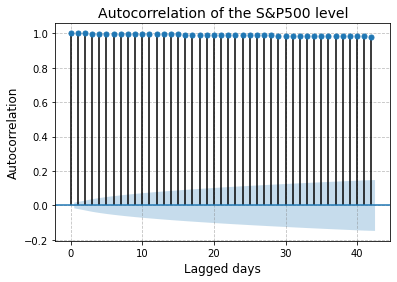

In [0]:
plot_acf(df['spindx'])
plt.title('Autocorrelation of the S&P500 level', fontsize = 14)
plt.ylabel('Autocorrelation', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Lagged days', fontsize = 12)
plt.xticks(fontsize = 10)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')

As expected, the lagged level of the S&P500 has significant predictive power on the current level. Of course, this is far from surprising. 

# Building the deep neural networks

### Importing packages

In [0]:
import tensorflow
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

## LSTM

### Splitting, normalising and preparing the time-series data 

In [0]:
#Splitting the data into train and test
data = df['spindx'].to_numpy()
data = data.reshape(-1,1)
data_train = data[:int(0.85*(len(df)))]
data_test = data[int(0.85*(len(df))):]

In [0]:
#Normalise the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(data_train)
test_scaled = scaler.transform(data_test)

In [0]:
#Building time series 
batch_size = 1
features = 1
time_steps = 10
num_steps_train = len(train_scaled) - time_steps
X_train = np.zeros([num_steps_train, time_steps, features])
y_train = np.zeros(num_steps_train)
for step in range(num_steps_train):
  X_train[step, :time_steps] = train_scaled[step:step + time_steps]
  y_train[step] = train_scaled[step + time_steps]

num_steps_test = len(test_scaled) - time_steps
X_test = np.zeros([num_steps_test, time_steps, features])
y_test = np.zeros(num_steps_test)
for step in range(num_steps_test):  
  X_test[step, :time_steps] = test_scaled[step:step + time_steps]
  y_test[step] = test_scaled[step + time_steps]


### Building & Summarising the LSTM model

In [0]:
#Hyperparameters
dropout = 0.2
epochs = 8
batch_size = 64
optimizer = Adam()

#Building the model
model = Sequential()
model.add(LSTM(128, input_shape = X_train.shape[1:],return_sequences= True ))
model.add(Dropout(dropout))
model.add(LSTM(64))
model.add(Dropout(dropout))
model.add(Dense(64,activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(32,activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizer)
 
#Summarising the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 128)           66560     
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

### Training the LSTM model

In [0]:
history_LSTM = model.fit(X_train, y_train, epochs=epochs, 
                         batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/8
191/191 [==============================] - 7s 36ms/step - loss: 0.0869 - val_loss: 1.1392
Epoch 2/8
191/191 [==============================] - 6s 32ms/step - loss: 0.0360 - val_loss: 0.6303
Epoch 3/8
191/191 [==============================] - 6s 33ms/step - loss: 0.0318 - val_loss: 0.2331
Epoch 4/8
191/191 [==============================] - 6s 32ms/step - loss: 0.0294 - val_loss: 0.1377
Epoch 5/8
191/191 [==============================] - 6s 32ms/step - loss: 0.0273 - val_loss: 0.1706
Epoch 6/8
191/191 [==============================] - 6s 32ms/step - loss: 0.0264 - val_loss: 0.0336
Epoch 7/8
191/191 [==============================] - 6s 32ms/step - loss: 0.0258 - val_loss: 0.0912
Epoch 8/8
191/191 [==============================] - 6s 32ms/step - loss: 0.0265 - val_loss: 0.0135


### Evaluating the LSTM model

In [0]:
#Predicting
y_pred = model.predict(X_test)
#flatten y_pred into 1D array
y_pred = y_pred.ravel()

In [0]:
#Transform data back to original scale (level of the S&P500)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

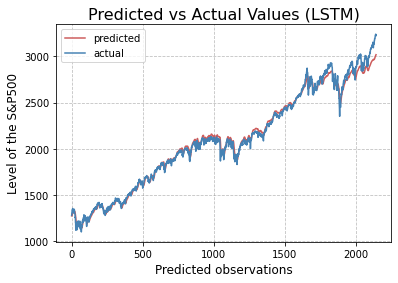

In [0]:
#Plotting the results
plt.plot(y_pred, label = 'predicted', color = 'indianred')
plt.plot(y_test, label = 'actual', color = 'steelblue')
plt.title('Predicted vs Actual Values (LSTM)', fontsize = 16)
plt.ylabel('Level of the S&P500', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Predicted observations', fontsize = 12)
plt.xticks(fontsize = 10)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.legend()
plt.show()

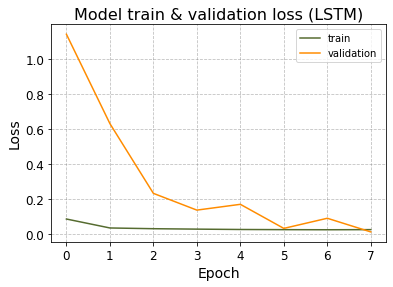

In [0]:
#Plotting the loss function
plt.plot(history_LSTM.history['loss'], color = 'darkolivegreen')
plt.plot(history_LSTM.history['val_loss'], color = 'darkorange')
plt.title('Model train & validation loss (LSTM)', fontsize = 16)
plt.ylabel('Loss', fontsize = 14)
plt.yticks(fontsize = 12)
plt.xlabel('Epoch', fontsize = 14)
plt.xticks(fontsize = 12)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print('R2: {:.2f}'.format(r2))

R2: 0.99


This suggests, that our model can explain 99% of the variation in the actual levels of the S&P500. 

Let's look at the median error of the LSTM model.

In [0]:
from sklearn.metrics import median_absolute_error
mean_error = median_absolute_error(y_test, y_pred)
print('Median error in the level of S&P500: {:.2f} points'.format(mean_error))

Median error in the level of S&P500: 25.55 points


Let's calculate the percentual error and visualise the results. 

In [0]:
dif = y_test - y_pred
dif_perc = (dif/y_test)*100
df = pd.DataFrame({'y_test':y_test,
                   'y_pred':y_pred,
                   'difference':dif,
                   '%difference':dif_perc})
mean_dif_perc = df['%difference'].abs().mean()
print('Mean percentual error: {:.2f}%'.format(mean_dif_perc))

Mean percentual error: 1.63%


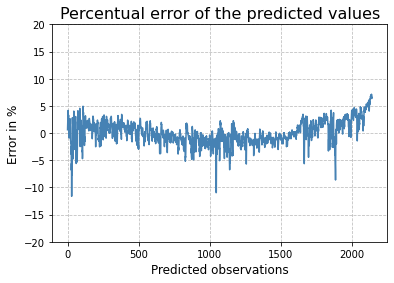

In [0]:
plt.plot(df['%difference'], color = 'steelblue')
plt.ylim(-20,20)
plt.title('Percentual error of the predicted values', fontsize = 16)
plt.ylabel('Error in %', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Predicted observations', fontsize = 12)
plt.xticks(fontsize = 10)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.show()

For our (educational) purpose, these results are a success and we are happy with a mean error of 1.63%. We are aware of the fact that for professional trading / predicting purposes, our model depicts a lack of accuracy. For further improvements, see below.

## Regular deep neural network

### Preparing and splitting the time series data

In [0]:
time_steps = 10
num_steps_train = len(train_scaled) - time_steps
X_train = np.zeros([num_steps_train, time_steps])
y_train = np.zeros(num_steps_train)
for step in range(num_steps_train):
  X_train[step, :time_steps] = train_scaled[step:step + time_steps,0]
  y_train[step] = train_scaled[step + time_steps]

num_steps_test = len(test_scaled) - time_steps
X_test = np.zeros([num_steps_test, time_steps])
y_test = np.zeros(num_steps_test)
for step in range(num_steps_test):  
  X_test[step, :time_steps] = test_scaled[step:step + time_steps,0]
  y_test[step] = test_scaled[step + time_steps]

### Building & Summarising the DNN model

In [0]:
#Hyperparameters (same as for LSTM to ensure comparability)
dropout = dropout
epochs = epochs
batch_size = batch_size
optimizer = optimizer

#Building the model
model_DNN = Sequential()
model_DNN.add(Dense(128,activation='relu', input_shape = X_train.shape[1:]))
model_DNN.add(Dropout(dropout))
model_DNN.add(Dense(64,activation='relu'))
model_DNN.add(Dropout(dropout))
model_DNN.add(Dense(32,activation='relu'))
model_DNN.add(Dropout(dropout))
model_DNN.add(Dense(1))
model_DNN.compile(loss='mean_squared_error', 
                   optimizer=optimizer)

#Summarising the model
model_DNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1408      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

### Training the DNN model 

In [0]:
history_DNN = model_DNN.fit(X_train, y_train, epochs=epochs, 
                            batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/8
191/191 [==============================] - 0s 3ms/step - loss: 0.0841 - val_loss: 0.3811
Epoch 2/8
191/191 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.6614
Epoch 3/8
191/191 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.5349
Epoch 4/8
191/191 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.1591
Epoch 5/8
191/191 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.1188
Epoch 6/8
191/191 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.2880
Epoch 7/8
191/191 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1365
Epoch 8/8
191/191 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0685


### Evaluating the DNN 

In [0]:
#Predicting
y_pred_DNN = model_DNN.predict(X_test)
#flatten y_pred_DNN into 1D array
y_pred_DNN = y_pred_DNN.ravel()

In [0]:
#Transform data back to original scale (level of the S&P500)
y_pred_DNN = scaler.inverse_transform(y_pred_DNN)
y_test = scaler.inverse_transform(y_test)

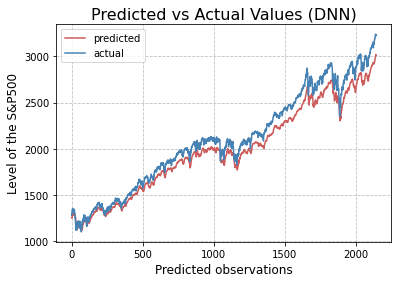

In [0]:
#Plotting the results
plt.plot(y_pred_DNN, label = 'predicted', color = 'indianred')
plt.plot(y_test, label = 'actual', color = 'steelblue')
plt.title('Predicted vs Actual Values (DNN)', fontsize = 16)
plt.ylabel('Level of the S&P500', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Predicted observations', fontsize = 12)
plt.xticks(fontsize = 10)
plt.legend()
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.show()

Interesting observation: The DNN seems to constantly provide a prediction which is below the actual value of the S&P500. One explanation for this might be that in recent years the S&P500 has risen to levels significantly above anything the models have been trained on. The DNN's prediction is only based on the previous level, whereas the LSTM recognizes tendencies in the data by including the time-series. This allows the LSTM to make more accurate predictions, even in spheres, which it has not seen before. 

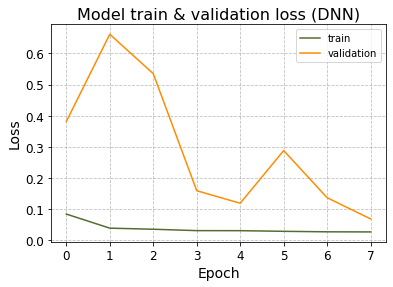

In [0]:
#Plotting the loss function
plt.plot(history_DNN.history['loss'], color = 'darkolivegreen')
plt.plot(history_DNN.history['val_loss'], color = 'darkorange')
plt.title('Model train & validation loss (DNN)', fontsize = 16)
plt.ylabel('Loss', fontsize = 14)
plt.yticks(fontsize = 12)
plt.xlabel('Epoch', fontsize = 14)
plt.xticks(fontsize = 12)
plt.legend(['train', 'validation'], loc='upper right')
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.show()

In [0]:
r2 = r2_score(y_test, y_pred_DNN)
print('R2: {:.2f}'.format(r2))

R2: 0.95


This suggests, that our model can explain 95% of the variation in the actual levels of the S&P500. 

Let's look at the median error of the DNN model.

In [0]:
median_error = median_absolute_error(y_test, y_pred_DNN)
print('Median error in the level of S&P500: {:.2f} points'.format(median_error))

Median error in the level of S&P500: 105.75 points


Let's calculate the percentual error and visualise the results: 

In [0]:
dif = y_test - y_pred_DNN
dif_perc = (dif/y_test)*100
df = pd.DataFrame({'y_test':y_test,
                   'y_pred':y_pred_DNN,
                   'difference':dif,
                   '%difference':dif_perc})
mean_dif_perc = df['%difference'].abs().mean()
print('Mean percentual error: {:.2f}%'.format(mean_dif_perc))

Mean percentual error: 4.88%


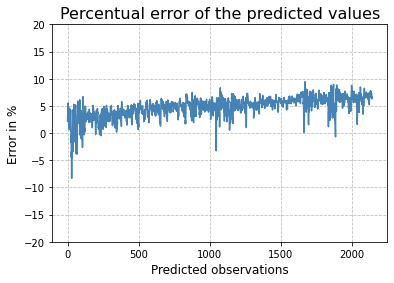

In [0]:
plt.plot(df['%difference'], color = 'steelblue')
plt.ylim(-20,20)
plt.title('Percentual error of the predicted values', fontsize = 16)
plt.ylabel('Error in %', fontsize = 12)
plt.yticks(fontsize = 10)
plt.xlabel('Predicted observations', fontsize = 12)
plt.xticks(fontsize = 10)
plt.grid(color = 'grey', alpha = 0.5, linestyle = '--')
plt.show()

It can be seen that the average error of the LSTM model at 1.63% is significantly below that of the DNN model at 4.88%. Additionally, the LSTM can explain 99% of the variation in the test data compared to the DNN, which can only explain 95%. 

# Conclusion

An LSTM is better suited to predict the future development of the S&P500 than conventional deep neural networks. The analysis of the autocorrelation of the squared log returns and the level of the S&P500 shows that the future value significantly correlates with the previous ones. Thus, if a time sequence is included, a better prediction accuracy can be expected. Upswings and downturns are recognized as such and taken into account when calculating the future value. The LSTM learns independently with which weighting the past values should be included, so that it is not necessary for the user to find out the appropriate length of the time sequence. 
The advantage of the higher prediction accuracy comes at the price of a higher computational cost in the training phase of the LSTM compared to the conventional deep neural network. This is mainly due to the significantly higher number of trainable parameters in the LSTM. In this case, the number of trainable parameters in the LSTM is 122,241 and in the DNN 11,777.

# Further Improvements

All in all, one has to note that the purpose of this project was to get hands on experience on recurrent neural networks (LSTMs in particular) and their application on time-series data. Thus, there exists a long list of possible improvements for the future. Some of which, we have noted down here:
*   *More (time-series) data/ features*: This might include the constitutent equities of the S&P500, futures, the risk-free rate (US government bonds), corporate bonds, inflation, etc. This will then also include the process of feature engineering and dimensionality reduction (such as with a Principal Component Analysis). 
*   *More computing power*: This would also require the employment of a GPU (rather than the CPU of our personal computers).
*   *Hyperparameter search*: With more computing power available, a hyperparameter search can be deployed to find the best parameters for the neural networks. 
*   *Employ other econometric models*: The results of our analysis could be weighted against the performance of traditional econometric models or chart analysis techniques (such as regular Time Series Regression Models).
*   *Trading strategies*: In the future, we might connect the model with an API providing minutely data on stock market movements. This will allow us to update our model with current data and build a trading strategy upon that. However, for this the model's accuracy will have to be improved significantly. 


# References / Further Readings

[1] Cont, R.(2001). Empirical properties of asset returns: stylized facts and statistical issues. 
Quantitative Finance, 1, 223-236. http://finance.martinsewell.com/stylized-facts/dependence/Cont2001.pdf

[2] Bucci, A.(2019). Realized Volatility Forecasting with Neural Networks. 
MPRA Paper. https://mpra.ub.uni-muenchen.de/95443/

[3]D. M. Q. Nelson, A. C. M. Pereira and R. A. de Oliveira, "Stock market's price movement prediction with LSTM neural networks," 2017 International Joint Conference on Neural Networks (IJCNN), Anchorage, AK, 2017, pp. 1419-1426.

[4] HOCHREITER, Sepp; SCHMIDHUBER, Jürgen. Long short-term memory. Neural computation, 1997, 9. Jg., Nr. 8, S. 1735-1780.

[5] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

&copy; Pierre Bourdon & Eike Wefelnberg